In [1]:
import numpy as np
import cv2
import os
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


/Users/mh/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def load_images_from_folder(folder):
    images = {}
    for filename in os.listdir(folder):
        category = []
        path = folder + "/" + filename
        for cat in os.listdir(path):
            img = cv2.imread(path + "/" + cat,0)
            
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            if img is not None:
                
                img=cv2.resize(img, (256, 256))
                category.append(img)
        images[filename] = category
    return images


In [3]:
images = load_images_from_folder("../data/train") 
len(images)

Corrupt JPEG data: 10 extraneous bytes before marker 0xd9


50

In [5]:
test = load_images_from_folder("../data/test")

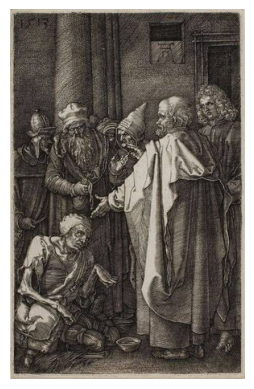

In [6]:
def output_image(image_path):
    # Read the image
    image = mpimg.imread(image_path)

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.show()
    return image

# Example usage:
image_path = "../data/train/Albrecht_Durer/Albrecht_Durer_4.jpg"  # Replace with the path to your image
imagetest=output_image(image_path)

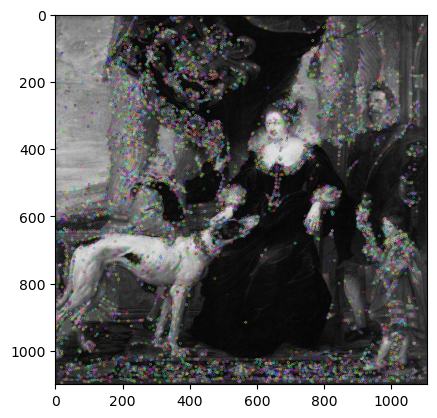

In [13]:
%matplotlib inline

#reading image
img1 = cv2.imread("../data/train/Peter_Paul_Rubens/Peter_Paul_Rubens_87.jpg")  
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img_1 = cv2.drawKeypoints(gray1,keypoints1,img1)
plt.imshow(img_1)


In [14]:
def sift_features(images):
    sift_vectors = {}
    descriptor_list = []
    sift = cv2.xfeatures2d.SIFT_create()
    for key,value in images.items():
        features = []
        for img in value:
            kp, des = sift.detectAndCompute(img,None)
           
            
            descriptor_list.extend(des)
            features.append(des)
        sift_vectors[key] = features
    return [descriptor_list, sift_vectors]

In [15]:
sifts = sift_features(images) 
# Takes the descriptor list which is unordered one
descriptor_list = sifts[0] 
# Takes the sift features that is seperated class by class for train data
all_bovw_feature = sifts[1] 
# Takes the sift features that is seperated class by class for test data
test_bovw_feature = sift_features(test)[1] 

[ WARN:0@313.167] global shadow_sift.hpp:15 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


In [ ]:
keypoints_descriptors_dict = {}  
for folder in os.listdir("../data/train"):  
    folder_path = os.path.join("../data/train", folder)
    if os.path.isdir(folder_path):
        images = [os.path.join(folder_path, image) for image in os.listdir(folder_path) if image.endswith(".jpg")]
        #print(f"Number of .jpg images found in folder {folder_path}: {len(images)}")
        for filename in images:
            img = cv2.imread(filename)
            keypoints, descriptors = sift.detectAndCompute(img, None)
            keypoints_descriptors_dict[filename] = {'keypoints': keypoints, 'descriptors': descriptors}

In [9]:
def kmeans(k, descriptor_list):
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_ 
    return visual_words


In [10]:
# Takes the central points which is visual words  
visual_words = kmeans(60, descriptor_list) 

In [ ]:
def quantize_descriptors(descriptors, k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(descriptors)
    return kmeans

In [ ]:
def assign_visual_words(descriptors, visual_words):
    labels = visual_words.predict(descriptors)
    return labels

In [ ]:
def image_class(all_bovw, centers):
    dict_feature = {}
    for key,value in all_bovw.items(): 
        category = []
        for img in value:
            histogram = np.zeros(len(centers))
            for each_feature in img:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature
    
# Creates histograms for train data    
bovw_train = image_class(all_bovw_feature, visual_words) 
# Creates histograms for test data
bovw_test = image_class(test_bovw_feature, visual_words) 

In [ ]:
def knn(images, tests):
    num_test = 0
    correct_predict = 0
    class_based = {}
    
    for test_key, test_val in tests.items():
        class_based[test_key] = [0, 0] # [correct, all]
        for tst in test_val:
            predict_start = 0
            #print(test_key)
            minimum = 0
            key = "a" #predicted
            for train_key, train_val in images.items():
                for train in train_val:
                    if(predict_start == 0):
                        minimum = distance.euclidean(tst, train)
                        #minimum = L1_dist(tst,train)
                        key = train_key
                        predict_start += 1
                    else:
                        dist = distance.euclidean(tst, train)
                        #dist = L1_dist(tst,train)
                        if(dist < minimum):
                            minimum = dist
                            key = train_key
            
            if(test_key == key):
                correct_predict += 1
                class_based[test_key][0] += 1
            num_test += 1
            class_based[test_key][1] += 1
            #print(minimum)
    return [num_test, correct_predict, class_based]
    

In [ ]:
results_bowl = knn(bovw_train, bovw_test) 


In [ ]:
def accuracy(results):
    avg_accuracy = (results[1] / results[0]) * 100
    print("Average accuracy: %" + str(avg_accuracy))
    print("\nClass based accuracies: \n")
    for key,value in results[2].items():
        acc = (value[0] / value[1]) * 100
        print(key + " : %" + str(acc))
        
# Calculates the accuracies and write the results to the console.       
accuracy(results_bowl)